In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from copy import deepcopy
from urllib.parse import unquote, quote
from datetime import datetime
import requests, json, re

def response_to_revisions(json_response):
    if type(json_response['query']['pages']) == dict:
        page_id = list(json_response['query']['pages'].keys())[0]
        return json_response['query']['pages'][page_id]['revisions']
    elif type(json_response['query']['pages']) == list:
        return json_response['query']['pages'][0]['revisions']
    else:
        raise ValueError("There are no revisions in the JSON")
        
def get_page_revisions(page_title,
                       endpoint='en.wikipedia.org/w/api.php',
                       redirects=True):
    """Takes Wikipedia page title and returns a DataFrame of revisions
    
    page_title - a string with the title of the page on Wikipedia
    endpoint - a string that points to the web address of the API.
        This defaults to the English Wikipedia endpoint: 'en.wikipedia.org/w/api.php'
        Changing the two letter language code will return a different language edition
        The Wikia/Fandom endpoints are slightly different, e.g. 'starwars.wikia.com/api.php'
    redirects - a Boolean value for whether to follow redirects to another page
        
    Returns:
    df - a pandas DataFrame where each row is a revision and columns correspond
         to meta-data such as parentid, revid, sha1, size, timestamp, and user name
    """
    
    # A container to store all the revisions
    revision_list = list()
    
    # Set up the query
    query_url = "https://{0}".format(endpoint)
    query_params = {}
    query_params['action'] = 'query'
    query_params['titles'] = page_title
    query_params['prop'] = 'revisions'
    query_params['rvprop'] = 'ids|userid|comment|timestamp|user|size|sha1'
    query_params['rvlimit'] = 500
    query_params['rvdir'] = 'newer'
    query_params['format'] = 'json'
    query_params['redirects'] = redirects
    query_params['formatversion'] = 2
    
    # Make the query
    json_response = requests.get(url = query_url, params = query_params).json()

    # Add the temporary list to the parent list
    revision_list += response_to_revisions(json_response)

    # Loop for the rest of the revisions
    while True:

        # Newer versions of the API return paginated results this way
        if 'continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvcontinue'] = json_response['continue']['rvcontinue']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # Older versions of the API return paginated results this way
        elif 'query-continue' in json_response:
            query_continue_params = deepcopy(query_params)
            query_continue_params['rvstartid'] = json_response['query-continue']['revisions']['rvstartid']
            json_response = requests.get(url = query_url, params = query_continue_params).json()
            revision_list += response_to_revisions(json_response)
        
        # If there are no more revisions, stop
        else:
            break

    # Convert to a DataFrame
    df = pd.DataFrame(revision_list)

    # Add in some helpful fields to the DataFrame
    df['page'] = page_title
    df['userid'] = df['userid'].fillna(0).apply(lambda x:str(int(x)))
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x:x.date())
    df['diff'] = df['size'].diff()
    df['lag'] = df['timestamp'].diff()/pd.Timedelta(1,'s')
    df['age'] = (df['timestamp'] - df['timestamp'].min())/pd.Timedelta(1,'d')

    return df

def get_pageviews(page_title,endpoint='en.wikipedia.org',
                  date_from='20150701',
                  date_to=str(datetime.today().date()).replace('-','')):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701 (earliest date)
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    df - a DataFrame indexed by date and multi-columned by agent and access type
    """
    quoted_page_title = quote(page_title, safe='')
    date_from = datetime.strftime(pd.to_datetime(date_from),'%Y%m%d')
    date_to = datetime.strftime(pd.to_datetime(date_to),'%Y%m%d')
    
    #for access in ['all-access','desktop','mobile-app','mobile-web']:
    #for agent in ['all-agents','user','spider','bot']:
    s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,endpoint,'all-access','user',date_from,date_to)
    json_response = requests.get(s).json()
    
    if 'items' in json_response:
        df = pd.DataFrame(json_response['items'])
    else:
        raise KeyError('There is no "items" key in the JSON response.')
        
    df = df[['timestamp','views']]
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
    s = df.set_index('timestamp')['views']
        
    return s

In [3]:
banksy_revs_df = get_page_revisions('Banksy')
banksy_revs_df.head()

,anon,comment,parentid,revid,sha1,sha1hidden,size,suppressed,timestamp,user,userid,page,date,diff,lag,age
0,NaN,,0,1924017,62f5f676eb51a52aa49756b3a97efc5b70d8086f,NaN,26,NaN,2003-12-10 16:57:59+00:00,Pete boon,33279,Banksy,2003-12-10,NaN,NaN,0.000000
1,NaN,,1924017,1924340,fab3fa7051096b3793c137e8a95fff585c0f4a1a,NaN,140,NaN,2003-12-10 16:59:37+00:00,Pete boon,33279,Banksy,2003-12-10,114.0,98.0,0.001134
2,NaN,fmt,1924340,2679587,c3f2855d2c961ece8ae0834e44e0ded3680affa5,NaN,157,NaN,2003-12-10 17:54:52+00:00,Evercat,10109,Banksy,2003-12-10,17.0,3315.0,0.039502
3,True,,2679587,2679592,660e62ce8de7a82d229e7881bbe099cfd45d8534,NaN,426,NaN,2004-03-08 15:03:05+00:00,62.255.64.5,0,Banksy,2004-03-08,269.0,7679293.0,88.920208
4,True,,2679592,2849724,100ee3958e0002a2d3f87a8859c1deca31ad1463,NaN,450,NaN,2004-03-08 15:03:45+00:00,62.255.64.5,0,Banksy,2004-03-08,24.0,40.0,88.920671


In [4]:
# Define aggregation functions for columns
agg_d = {'sha1':pd.Series.nunique,
         'user':pd.Series.nunique,
         'size':lambda x:x.iloc[-1], # https://stackoverflow.com/a/15002718/1574687
         'diff':np.median,
         'revid':lambda x:x.iloc[-1]}

# Perform groupby-aggregation by grouping on date
banksy_df = banksy_revs_df.groupby('date').agg(agg_d)

# Rename columns
banksy_df.rename(columns={'sha1':'revisions','user':'users','size':'length'},inplace=True)

# Fix the index to be true datetimes
banksy_df.index = pd.to_datetime(banksy_df.index)

# Inspect
banksy_df.head()

,revisions,users,length,diff,revid
date,,,,,
2003-12-10,3,2,157,65.5,2679587
2004-03-08,2,1,450,146.5,2849724
2004-03-20,2,1,463,6.5,2891296
2004-03-23,4,1,1025,82.0,2911208
2004-03-25,1,1,1274,249.0,2926215


In [5]:
# Define starting date - start from first day of article to last day of article.
start = banksy_df.index.min()
stop = pd.datetime.today()

# Use date_range to define a range of dates from start to present
banksy_dates = pd.date_range(start,stop)

# Perform the reindex
banksy_reindexed_df = banksy_df.reindex(index=banksy_dates)

# Inspect
banksy_reindexed_df.head()

,revisions,users,length,diff,revid
2003-12-10,3.0,2.0,157.0,65.5,2679587.0
2003-12-11,NaN,NaN,NaN,NaN,NaN
2003-12-12,NaN,NaN,NaN,NaN,NaN
2003-12-13,NaN,NaN,NaN,NaN,NaN
2003-12-14,NaN,NaN,NaN,NaN,NaN


In [6]:
banksy_reindexed_df.tail()

,revisions,users,length,diff,revid
2019-09-24,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,NaN,NaN
2019-09-26,NaN,NaN,NaN,NaN,NaN
2019-09-27,NaN,NaN,NaN,NaN,NaN
2019-09-28,NaN,NaN,NaN,NaN,NaN


In [7]:
# if there is an NA convert to zero.
banksy_reindexed_df['revisions'].fillna(0,inplace=True)
banksy_reindexed_df.head(10)

,revisions,users,length,diff,revid
2003-12-10,3.0,2.0,157.0,65.5,2679587.0
2003-12-11,0.0,NaN,NaN,NaN,NaN
2003-12-12,0.0,NaN,NaN,NaN,NaN
2003-12-13,0.0,NaN,NaN,NaN,NaN
2003-12-14,0.0,NaN,NaN,NaN,NaN
2003-12-15,0.0,NaN,NaN,NaN,NaN
2003-12-16,0.0,NaN,NaN,NaN,NaN
2003-12-17,0.0,NaN,NaN,NaN,NaN
2003-12-18,0.0,NaN,NaN,NaN,NaN
2003-12-19,0.0,NaN,NaN,NaN,NaN


In [8]:
banksy_reindexed_df.tail(10)

,revisions,users,length,diff,revid
2019-09-19,0.0,NaN,NaN,NaN,NaN
2019-09-20,0.0,NaN,NaN,NaN,NaN
2019-09-21,0.0,NaN,NaN,NaN,NaN
2019-09-22,0.0,NaN,NaN,NaN,NaN
2019-09-23,0.0,NaN,NaN,NaN,NaN
2019-09-24,0.0,NaN,NaN,NaN,NaN
2019-09-25,0.0,NaN,NaN,NaN,NaN
2019-09-26,0.0,NaN,NaN,NaN,NaN
2019-09-27,0.0,NaN,NaN,NaN,NaN
2019-09-28,0.0,NaN,NaN,NaN,NaN


In [9]:
# If no activity in the article that day fill in with zero.
# Bc no activity the length of article is same length as first day... 100
banksy_reindexed_df['users'].fillna(0,inplace=True)
banksy_reindexed_df.head(10)

,revisions,users,length,diff,revid
2003-12-10,3.0,2.0,157.0,65.5,2679587.0
2003-12-11,0.0,0.0,NaN,NaN,NaN
2003-12-12,0.0,0.0,NaN,NaN,NaN
2003-12-13,0.0,0.0,NaN,NaN,NaN
2003-12-14,0.0,0.0,NaN,NaN,NaN
2003-12-15,0.0,0.0,NaN,NaN,NaN
2003-12-16,0.0,0.0,NaN,NaN,NaN
2003-12-17,0.0,0.0,NaN,NaN,NaN
2003-12-18,0.0,0.0,NaN,NaN,NaN
2003-12-19,0.0,0.0,NaN,NaN,NaN


In [10]:
banksy_reindexed_df['length'].fillna(method='ffill',inplace=True)
banksy_reindexed_df.head(10) # compare head to tail

,revisions,users,length,diff,revid
2003-12-10,3.0,2.0,157.0,65.5,2679587.0
2003-12-11,0.0,0.0,157.0,NaN,NaN
2003-12-12,0.0,0.0,157.0,NaN,NaN
2003-12-13,0.0,0.0,157.0,NaN,NaN
2003-12-14,0.0,0.0,157.0,NaN,NaN
2003-12-15,0.0,0.0,157.0,NaN,NaN
2003-12-16,0.0,0.0,157.0,NaN,NaN
2003-12-17,0.0,0.0,157.0,NaN,NaN
2003-12-18,0.0,0.0,157.0,NaN,NaN
2003-12-19,0.0,0.0,157.0,NaN,NaN


In [11]:
banksy_reindexed_df['diff'].fillna(0,inplace=True)
banksy_reindexed_df.head(10)

,revisions,users,length,diff,revid
2003-12-10,3.0,2.0,157.0,65.5,2679587.0
2003-12-11,0.0,0.0,157.0,0.0,NaN
2003-12-12,0.0,0.0,157.0,0.0,NaN
2003-12-13,0.0,0.0,157.0,0.0,NaN
2003-12-14,0.0,0.0,157.0,0.0,NaN
2003-12-15,0.0,0.0,157.0,0.0,NaN
2003-12-16,0.0,0.0,157.0,0.0,NaN
2003-12-17,0.0,0.0,157.0,0.0,NaN
2003-12-18,0.0,0.0,157.0,0.0,NaN
2003-12-19,0.0,0.0,157.0,0.0,NaN


In [12]:
banksy_reindexed_df['revid'].fillna(method='ffill',inplace=True)
banksy_reindexed_df.tail(10)

,revisions,users,length,diff,revid
2019-09-19,0.0,0.0,134060.0,0.0,915849355.0
2019-09-20,0.0,0.0,134060.0,0.0,915849355.0
2019-09-21,0.0,0.0,134060.0,0.0,915849355.0
2019-09-22,0.0,0.0,134060.0,0.0,915849355.0
2019-09-23,0.0,0.0,134060.0,0.0,915849355.0
2019-09-24,0.0,0.0,134060.0,0.0,915849355.0
2019-09-25,0.0,0.0,134060.0,0.0,915849355.0
2019-09-26,0.0,0.0,134060.0,0.0,915849355.0
2019-09-27,0.0,0.0,134060.0,0.0,915849355.0
2019-09-28,0.0,0.0,134060.0,0.0,915849355.0


## Length of article over time

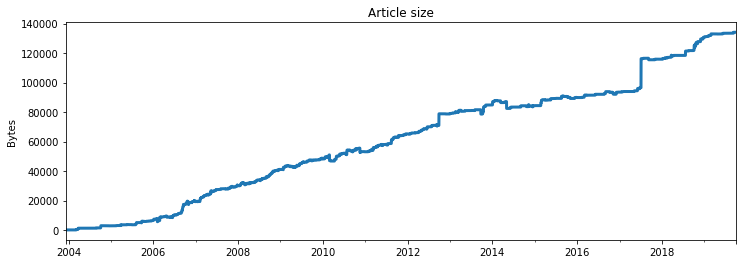

In [13]:
f,ax = plt.subplots(1,1,figsize=(12,4))

banksy_reindexed_df['length'].plot(lw=3,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Bytes')
ax.set_title('Article size');

## Revisions of article over time

Text(0.5, 1.0, 'Revisions')

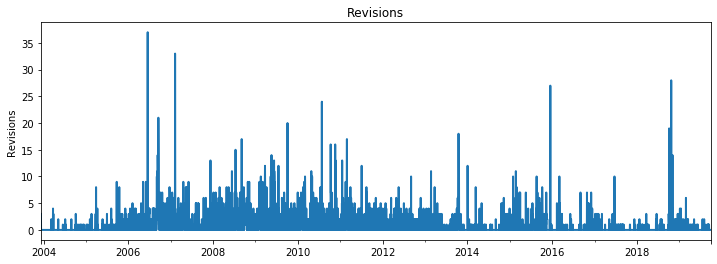

In [14]:
f,ax = plt.subplots(1,1,figsize=(12,4))

banksy_reindexed_df['revisions'].plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Revisions')
ax.set_title('Revisions')

## Lots of revisions going on

In [15]:
# See how long versions of the article lasted by day.
banksy_reindexed_df['revid'].value_counts().head(10)

2679587.0      89
835993817.0    64
727368670.0    55
799737597.0    54
697009741.0    47
5508726.0      47
3486000.0      42
901336638.0    40
4117979.0      40
855935237.0    40
Name: revid, dtype: int64

In [16]:
# Hw many times did someone view the page a day?
banksy_pageviews = get_pageviews('Banksy')
banksy_pageviews.head()

timestamp
2015-07-01    6150
2015-07-02    3587
2015-07-03    3432
2015-07-04    2828
2015-07-05    2901
Name: views, dtype: int64

In [17]:
banksy_pageviews = get_pageviews('Banksy')
banksy_pageviews.tail()

timestamp
2019-09-23    4058
2019-09-24    4180
2019-09-25    4082
2019-09-26    3664
2019-09-27    3967
Name: views, dtype: int64

## Lots of views in late 2018...what happened?

Text(0.5, 1.0, 'Pageviews')

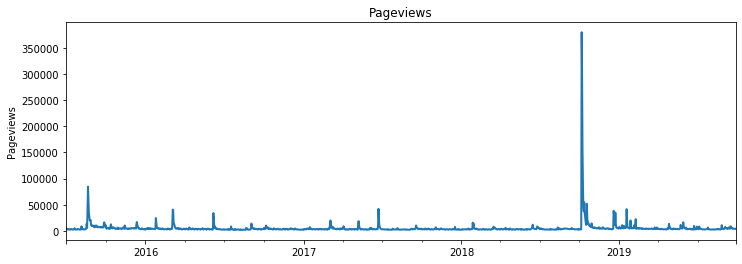

In [18]:
f,ax = plt.subplots(1,1,figsize=(12,4))

banksy_pageviews.plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Pageviews')

## https://www.thefader.com/2018/10/18/banksy-video-shredded-painting 

## October 2018 Banksy shredded one of his most famous art works that was just bought for $1.3 Million

In [19]:
banksy_reindexed_df['pageviews'] = banksy_pageviews
banksy_reindexed_df.tail()

,revisions,users,length,diff,revid,pageviews
2019-09-24,0.0,0.0,134060.0,0.0,915849355.0,4180.0
2019-09-25,0.0,0.0,134060.0,0.0,915849355.0,4082.0
2019-09-26,0.0,0.0,134060.0,0.0,915849355.0,3664.0
2019-09-27,0.0,0.0,134060.0,0.0,915849355.0,3967.0
2019-09-28,0.0,0.0,134060.0,0.0,915849355.0,NaN


## People only really started looking at thw Wiki page late 2015! 

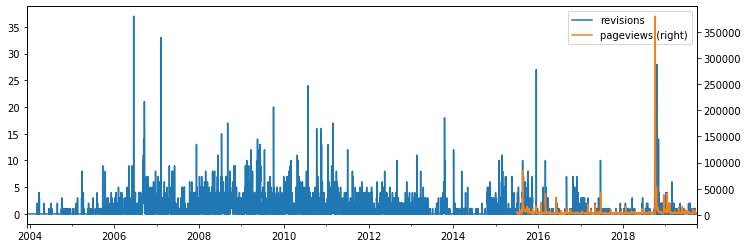

In [20]:
# put page vieews and revisions in a graph on top of each other. 
f,ax = plt.subplots(1,1,figsize=(12,4))

banksy_reindexed_df[['revisions','pageviews']].plot(secondary_y='pageviews',ax=ax)

In [21]:
banksy_reindexed_df[['revisions','pageviews']].apply(lambda x:np.log(x+1)).corr()

,revisions,pageviews
revisions,1.000000,0.390305
pageviews,0.390305,1.000000


## Maybe compare Banksy page views to other street artists?

In [22]:
vhils_revs_df = get_page_revisions('Vhils')
vhils_revs_df.head()

,anon,comment,parentid,revid,sha1,size,timestamp,user,userid,page,date,diff,lag,age
0,NaN,[[WP:AES|←]]Created page with 'VHILS is the ta...,0,275044910,69dc07e5a7358d358b4cf0f4247fb183ec08c6c5,1011,2009-03-04 23:48:44+00:00,Gadflyer100,7096416,Vhils,2009-03-04,NaN,NaN,0.000000
1,NaN,moved [[Vhils]] to [[VHILS]]:&#32;Cap. fix,275044910,275045323,69dc07e5a7358d358b4cf0f4247fb183ec08c6c5,1011,2009-03-04 23:50:34+00:00,Quantumobserver,7242225,Vhils,2009-03-04,0.0,110.0,0.001273
2,NaN,,275045323,275045797,1a4fe7c38523a99e404c8bc3320813f9c1b6e3af,1015,2009-03-04 23:52:44+00:00,Gadflyer100,7096416,Vhils,2009-03-04,4.0,130.0,0.002778
3,True,,275045797,280521407,80317e52dd776930d87e871f33f4f7906deac19c,1015,2009-03-29 23:03:36+00:00,78.86.13.86,0,Vhils,2009-03-29,0.0,2157052.0,24.968657
4,True,,280521407,280521503,fe6ba3fc6eed73ba8a24e1b1e710e47120436700,1024,2009-03-29 23:04:12+00:00,78.86.13.86,0,Vhils,2009-03-29,9.0,36.0,24.969074


In [23]:
# Define aggregation functions for columns
agg_d = {'sha1':pd.Series.nunique,
         'user':pd.Series.nunique,
         'size':lambda x:x.iloc[-1], # https://stackoverflow.com/a/15002718/1574687
         'diff':np.median,
         'revid':lambda x:x.iloc[-1]}

# Perform groupby-aggregation by grouping on date
vhils_df = vhils_revs_df.groupby('date').agg(agg_d)

# Rename columns
vhils_df.rename(columns={'sha1':'revisions','user':'users','size':'length'},inplace=True)

# Fix the index to be true datetimes
vhils_df.index = pd.to_datetime(vhils_df.index)

# Inspect
vhils_df.head()

,revisions,users,length,diff,revid
date,,,,,
2009-03-04,2,2,1015,2.0,275045797
2009-03-29,3,1,1146,9.0,280522758
2009-04-05,1,1,1076,-70.0,281886415
2009-05-30,1,1,1108,32.0,293328196
2009-08-02,4,1,1168,14.5,305632899


In [24]:
# Define starting date - start from first day of article to last day of article.
start = vhils_df.index.min()
stop = pd.datetime.today()

# Use date_range to define a range of dates from start to present
vhils_dates = pd.date_range(start,stop)

# Perform the reindex
vhils_reindexed_df = vhils_df.reindex(index=vhils_dates)

# Inspect
vhils_reindexed_df.head()

,revisions,users,length,diff,revid
2009-03-04,2.0,2.0,1015.0,2.0,275045797.0
2009-03-05,NaN,NaN,NaN,NaN,NaN
2009-03-06,NaN,NaN,NaN,NaN,NaN
2009-03-07,NaN,NaN,NaN,NaN,NaN
2009-03-08,NaN,NaN,NaN,NaN,NaN


In [25]:
vhils_reindexed_df.tail()

,revisions,users,length,diff,revid
2019-09-24,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,NaN,NaN
2019-09-26,NaN,NaN,NaN,NaN,NaN
2019-09-27,NaN,NaN,NaN,NaN,NaN
2019-09-28,NaN,NaN,NaN,NaN,NaN


In [26]:
vhils_reindexed_df['revisions'].fillna(0,inplace=True)
vhils_reindexed_df.head(10)

,revisions,users,length,diff,revid
2009-03-04,2.0,2.0,1015.0,2.0,275045797.0
2009-03-05,0.0,NaN,NaN,NaN,NaN
2009-03-06,0.0,NaN,NaN,NaN,NaN
2009-03-07,0.0,NaN,NaN,NaN,NaN
2009-03-08,0.0,NaN,NaN,NaN,NaN
2009-03-09,0.0,NaN,NaN,NaN,NaN
2009-03-10,0.0,NaN,NaN,NaN,NaN
2009-03-11,0.0,NaN,NaN,NaN,NaN
2009-03-12,0.0,NaN,NaN,NaN,NaN
2009-03-13,0.0,NaN,NaN,NaN,NaN


In [27]:
vhils_reindexed_df['users'].fillna(0,inplace=True)
vhils_reindexed_df.head(10)

,revisions,users,length,diff,revid
2009-03-04,2.0,2.0,1015.0,2.0,275045797.0
2009-03-05,0.0,0.0,NaN,NaN,NaN
2009-03-06,0.0,0.0,NaN,NaN,NaN
2009-03-07,0.0,0.0,NaN,NaN,NaN
2009-03-08,0.0,0.0,NaN,NaN,NaN
2009-03-09,0.0,0.0,NaN,NaN,NaN
2009-03-10,0.0,0.0,NaN,NaN,NaN
2009-03-11,0.0,0.0,NaN,NaN,NaN
2009-03-12,0.0,0.0,NaN,NaN,NaN
2009-03-13,0.0,0.0,NaN,NaN,NaN


In [28]:
vhils_reindexed_df['length'].fillna(method='ffill',inplace=True)
vhils_reindexed_df.head(10) # compare head to tail

,revisions,users,length,diff,revid
2009-03-04,2.0,2.0,1015.0,2.0,275045797.0
2009-03-05,0.0,0.0,1015.0,NaN,NaN
2009-03-06,0.0,0.0,1015.0,NaN,NaN
2009-03-07,0.0,0.0,1015.0,NaN,NaN
2009-03-08,0.0,0.0,1015.0,NaN,NaN
2009-03-09,0.0,0.0,1015.0,NaN,NaN
2009-03-10,0.0,0.0,1015.0,NaN,NaN
2009-03-11,0.0,0.0,1015.0,NaN,NaN
2009-03-12,0.0,0.0,1015.0,NaN,NaN
2009-03-13,0.0,0.0,1015.0,NaN,NaN


In [29]:
vhils_reindexed_df['diff'].fillna(0,inplace=True)
vhils_reindexed_df.head(10)

,revisions,users,length,diff,revid
2009-03-04,2.0,2.0,1015.0,2.0,275045797.0
2009-03-05,0.0,0.0,1015.0,0.0,NaN
2009-03-06,0.0,0.0,1015.0,0.0,NaN
2009-03-07,0.0,0.0,1015.0,0.0,NaN
2009-03-08,0.0,0.0,1015.0,0.0,NaN
2009-03-09,0.0,0.0,1015.0,0.0,NaN
2009-03-10,0.0,0.0,1015.0,0.0,NaN
2009-03-11,0.0,0.0,1015.0,0.0,NaN
2009-03-12,0.0,0.0,1015.0,0.0,NaN
2009-03-13,0.0,0.0,1015.0,0.0,NaN


In [30]:
vhils_reindexed_df['revid'].fillna(method='ffill',inplace=True)
vhils_reindexed_df.tail(10)

,revisions,users,length,diff,revid
2019-09-19,0.0,0.0,5660.0,0.0,883190704.0
2019-09-20,0.0,0.0,5660.0,0.0,883190704.0
2019-09-21,0.0,0.0,5660.0,0.0,883190704.0
2019-09-22,0.0,0.0,5660.0,0.0,883190704.0
2019-09-23,0.0,0.0,5660.0,0.0,883190704.0
2019-09-24,0.0,0.0,5660.0,0.0,883190704.0
2019-09-25,0.0,0.0,5660.0,0.0,883190704.0
2019-09-26,0.0,0.0,5660.0,0.0,883190704.0
2019-09-27,0.0,0.0,5660.0,0.0,883190704.0
2019-09-28,0.0,0.0,5660.0,0.0,883190704.0


## Length of article over time

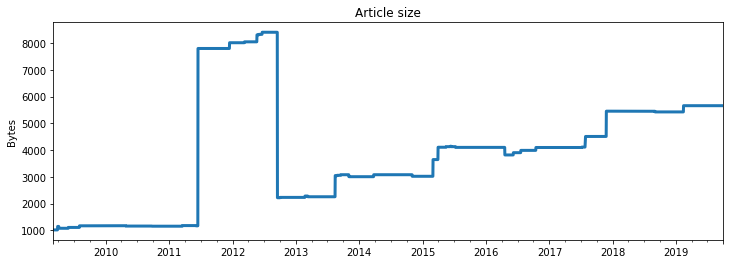

In [31]:
f,ax = plt.subplots(1,1,figsize=(12,4))

vhils_reindexed_df['length'].plot(lw=3,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Bytes')
ax.set_title('Article size');

## Revisions of article over time

Text(0.5, 1.0, 'Revisions')

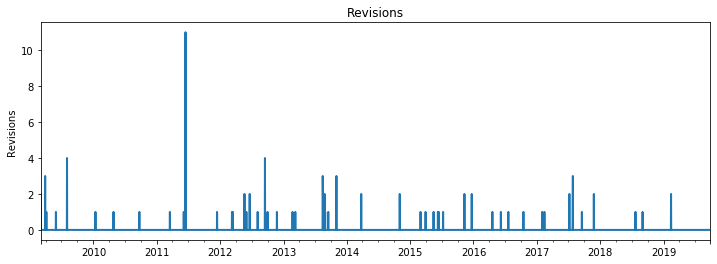

In [58]:
f,ax = plt.subplots(1,1,figsize=(12,4))

vhils_reindexed_df['revisions'].plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Revisions')
ax.set_title('Revisions')

Text(0.5, 1.0, 'Revisions')

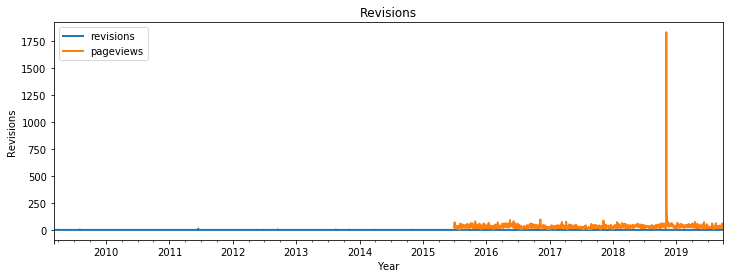

In [61]:
f,ax = plt.subplots(1,1,figsize=(12,4))

vhils_reindexed_df[['revisions','pageviews']].plot(lw=2,ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Revisions')
ax.set_title('Revisions')

In [33]:
vhils_pageviews = get_pageviews('Vhils')
vhils_pageviews.head()

timestamp
2015-07-01    25
2015-07-02    35
2015-07-03    70
2015-07-04    20
2015-07-05    40
Name: views, dtype: int64

In [34]:
vhils_pageviews = get_pageviews('Vhils')
vhils_pageviews.tail()

timestamp
2019-09-23    57
2019-09-24    36
2019-09-25    32
2019-09-26    40
2019-09-27    20
Name: views, dtype: int64

## Pageviews overtime

Text(0.5, 1.0, 'Pageviews')

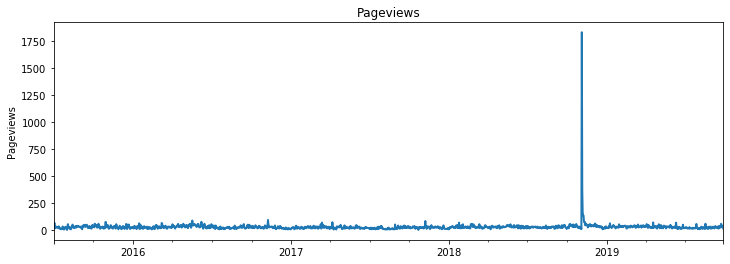

In [35]:
f,ax = plt.subplots(1,1,figsize=(12,4))

vhils_pageviews.plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Pageviews')

In [36]:
vhils_reindexed_df['pageviews'] = vhils_pageviews
vhils_reindexed_df.tail()

,revisions,users,length,diff,revid,pageviews
2019-09-24,0.0,0.0,5660.0,0.0,883190704.0,36.0
2019-09-25,0.0,0.0,5660.0,0.0,883190704.0,32.0
2019-09-26,0.0,0.0,5660.0,0.0,883190704.0,40.0
2019-09-27,0.0,0.0,5660.0,0.0,883190704.0,20.0
2019-09-28,0.0,0.0,5660.0,0.0,883190704.0,NaN


## Tried to select colors for the two plot but it didn't work out to great...OBVIOUSLY! If anyone knows what I can do, please help =)

## It seems like both artists were being viewed around the same timeline, with similar patterns however, Banksy seems to be much more popular.

In [37]:
monet_revs_df = get_page_revisions('Claude Monet')
monet_revs_df.head()

,anon,comment,parentid,revid,sha1,size,timestamp,user,userid,page,date,diff,lag,age
0,NaN,minor revisions. art school at a university i...,0,243565,954973258b7f426ed3fb1b5aefd65fbfbb090885,2340,2001-10-15 16:59:25+00:00,MichaelTinkler,18,Claude Monet,2001-10-15,NaN,NaN,0.000000
1,NaN,"better. not perfect, but better.",243565,243566,6ba070b655ea1dae5ce484d180888236adf5a383,2274,2001-10-15 17:08:37+00:00,MichaelTinkler,18,Claude Monet,2001-10-15,-66.0,552.0,0.006389
2,NaN,typo,379444244,380633975,d1fdd40a22986753b7cb311f603a15164c697109,2243,2001-10-19 12:46:45+00:00,MichaelTinkler,18,Claude Monet,2001-10-19,-31.0,329888.0,3.824537
3,NaN,Automated conversion,380633975,28815,83024a19f9ea732b68ef0764d83950c09e59f210,2276,2002-02-25 15:51:15+00:00,Conversion script,1226483,Claude Monet,2002-02-25,33.0,11156670.0,132.952662
4,NaN,*,28815,96094,4ca9bafe0674f8fcf846180b28c9fa361cb39fbb,2391,2002-03-13 00:30:32+00:00,Gianfranco,918,Claude Monet,2002-03-13,115.0,1327157.0,148.313275


In [38]:
agg_d = {'sha1':pd.Series.nunique,
         'user':pd.Series.nunique,
         'size':lambda x:x.iloc[-1], # https://stackoverflow.com/a/15002718/1574687
         'diff':np.median,
         'revid':lambda x:x.iloc[-1]}

# Perform groupby-aggregation by grouping on date
monet_df = monet_revs_df.groupby('date').agg(agg_d)

# Rename columns
monet_df.rename(columns={'sha1':'revisions','user':'users','size':'length'},inplace=True)

# Fix the index to be true datetimes
monet_df.index = pd.to_datetime(monet_df.index)

# Inspect
monet_df.head()

,revisions,users,length,diff,revid
date,,,,,
2001-10-15,2,1,2274,-66.0,243566
2001-10-19,1,1,2243,-31.0,380633975
2002-02-25,1,1,2276,33.0,28815
2002-03-13,1,1,2391,115.0,96094
2002-06-16,1,1,2361,-30.0,117107


In [39]:
monet_df.tail()

,revisions,users,length,diff,revid
date,,,,,
2019-08-17,1,1,53863,-15.0,911298687
2019-08-27,2,2,53857,-3.0,912784779
2019-09-06,1,1,53941,84.0,914250835
2019-09-08,2,2,53941,0.0,914607298
2019-09-16,2,2,54063,61.0,915999724


In [40]:
start = monet_df.index.min()
stop = pd.datetime.today()

# Use date_range to define a range of dates from start to present
monet_dates = pd.date_range(start,stop)

# Perform the reindex
monet_reindexed_df = monet_df.reindex(index=monet_dates)

# Inspect
monet_reindexed_df.head()

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,NaN,NaN,NaN,NaN,NaN
2001-10-17,NaN,NaN,NaN,NaN,NaN
2001-10-18,NaN,NaN,NaN,NaN,NaN
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0


In [41]:
monet_reindexed_df['revisions'].fillna(0,inplace=True)
monet_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,0.0,NaN,NaN,NaN,NaN
2001-10-17,0.0,NaN,NaN,NaN,NaN
2001-10-18,0.0,NaN,NaN,NaN,NaN
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0
2001-10-20,0.0,NaN,NaN,NaN,NaN
2001-10-21,0.0,NaN,NaN,NaN,NaN
2001-10-22,0.0,NaN,NaN,NaN,NaN
2001-10-23,0.0,NaN,NaN,NaN,NaN
2001-10-24,0.0,NaN,NaN,NaN,NaN


In [42]:
monet_reindexed_df['users'].fillna(0,inplace=True)
monet_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,0.0,0.0,NaN,NaN,NaN
2001-10-17,0.0,0.0,NaN,NaN,NaN
2001-10-18,0.0,0.0,NaN,NaN,NaN
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0
2001-10-20,0.0,0.0,NaN,NaN,NaN
2001-10-21,0.0,0.0,NaN,NaN,NaN
2001-10-22,0.0,0.0,NaN,NaN,NaN
2001-10-23,0.0,0.0,NaN,NaN,NaN
2001-10-24,0.0,0.0,NaN,NaN,NaN


In [43]:
monet_reindexed_df['length'].fillna(0,inplace=True)
monet_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,0.0,0.0,0.0,NaN,NaN
2001-10-17,0.0,0.0,0.0,NaN,NaN
2001-10-18,0.0,0.0,0.0,NaN,NaN
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0
2001-10-20,0.0,0.0,0.0,NaN,NaN
2001-10-21,0.0,0.0,0.0,NaN,NaN
2001-10-22,0.0,0.0,0.0,NaN,NaN
2001-10-23,0.0,0.0,0.0,NaN,NaN
2001-10-24,0.0,0.0,0.0,NaN,NaN


In [44]:
monet_reindexed_df['diff'].fillna(0,inplace=True)
monet_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,0.0,0.0,0.0,0.0,NaN
2001-10-17,0.0,0.0,0.0,0.0,NaN
2001-10-18,0.0,0.0,0.0,0.0,NaN
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0
2001-10-20,0.0,0.0,0.0,0.0,NaN
2001-10-21,0.0,0.0,0.0,0.0,NaN
2001-10-22,0.0,0.0,0.0,0.0,NaN
2001-10-23,0.0,0.0,0.0,0.0,NaN
2001-10-24,0.0,0.0,0.0,0.0,NaN


In [45]:
monet_reindexed_df['revid'].fillna(0,inplace=True)
monet_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-15,2.0,1.0,2274.0,-66.0,243566.0
2001-10-16,0.0,0.0,0.0,0.0,0.0
2001-10-17,0.0,0.0,0.0,0.0,0.0
2001-10-18,0.0,0.0,0.0,0.0,0.0
2001-10-19,1.0,1.0,2243.0,-31.0,380633975.0
2001-10-20,0.0,0.0,0.0,0.0,0.0
2001-10-21,0.0,0.0,0.0,0.0,0.0
2001-10-22,0.0,0.0,0.0,0.0,0.0
2001-10-23,0.0,0.0,0.0,0.0,0.0
2001-10-24,0.0,0.0,0.0,0.0,0.0


In [46]:
monet_pageviews = get_pageviews('Claude Monet')
monet_pageviews.head()

timestamp
2015-07-01    2651
2015-07-02    2571
2015-07-03    2007
2015-07-04    1856
2015-07-05    2271
Name: views, dtype: int64

Text(0.5, 1.0, 'Monet Pageviews')

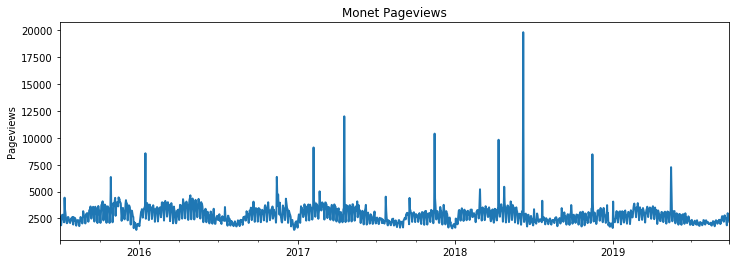

In [47]:
f,ax = plt.subplots(1,1,figsize=(12,4))

monet_pageviews.plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Monet Pageviews')

In [48]:
renoir_pageviews = get_pageviews('Pierre-Auguste Renoir')
renoir_pageviews.head()

timestamp
2015-07-01    1064
2015-07-02    1093
2015-07-03     849
2015-07-04     868
2015-07-05    1064
Name: views, dtype: int64

Text(0.5, 1.0, 'Renoir Pageviews')

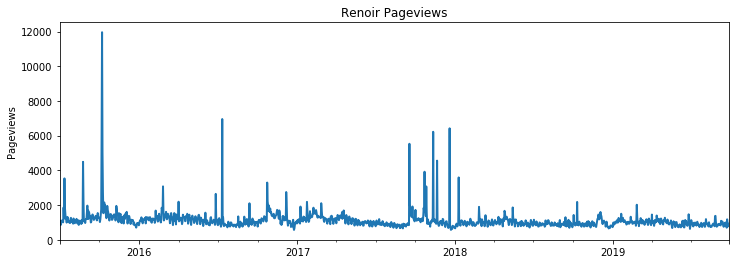

In [49]:
f,ax = plt.subplots(1,1,figsize=(12,4))

renoir_pageviews.plot(lw=2,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Renoir Pageviews')

In [64]:
picasso_revs_df = get_page_revisions('Pablo Picasso')
picasso_revs_df.head()

,anon,comment,commenthidden,parentid,revid,sha1,size,timestamp,user,userid,page,date,diff,lag,age
0,True,*,NaN,0,274923,7647cea841da4ed4e1995c6084b39c92b9e4b892,3557,2001-10-12 19:03:39+00:00,205.188.199.xxx,0,Pablo Picasso,2001-10-12,NaN,NaN,0.000000
1,NaN,*,NaN,274923,274924,fa415d043ff730796fa6c62a6d6449582c86c4b8,3551,2001-10-12 19:06:18+00:00,Paul Drye,6,Pablo Picasso,2001-10-12,-6.0,159.0,0.001840
2,True,*,NaN,361562677,363200850,aa5fae0358924e03f8b26c4f674965f4c47b41ba,3498,2001-11-29 19:33:59+00:00,200.191.188.xxx,0,Pablo Picasso,2001-11-29,-53.0,4148861.0,48.021065
3,NaN,Automated conversion,NaN,363200850,12322,f2cdc1d98c2e2d26332d61bf73d368f2946c96cb,3549,2002-02-16 18:15:22+00:00,Conversion script,1226483,Pablo Picasso,2002-02-16,51.0,6820883.0,126.966470
4,NaN,English usage; formatting; return of ''Guernic...,NaN,12322,68379,66db47c5649faa6d96c95ecbc9d83c6a1f5442bb,3709,2002-02-25 15:51:15+00:00,Vicki Rosenzweig,59,Pablo Picasso,2002-02-25,160.0,768953.0,135.866389


In [65]:
# Define aggregation functions for columns
agg_d = {'sha1':pd.Series.nunique,
         'user':pd.Series.nunique,
         'size':lambda x:x.iloc[-1], # https://stackoverflow.com/a/15002718/1574687
         'diff':np.median,
         'revid':lambda x:x.iloc[-1]}

# Perform groupby-aggregation by grouping on date
picasso_df = picasso_revs_df.groupby('date').agg(agg_d)

# Rename columns
picasso_df.rename(columns={'sha1':'revisions','user':'users','size':'length'},inplace=True)

# Fix the index to be true datetimes
picasso_df.index = pd.to_datetime(picasso_df.index)

# Inspect
picasso_df.head()

,revisions,users,length,diff,revid
date,,,,,
2001-10-12,2,2,3551,-6.0,274924
2001-11-29,1,1,3498,-53.0,363200850
2002-02-16,1,1,3549,51.0,12322
2002-02-25,1,1,3709,160.0,68379
2002-04-27,1,1,3732,23.0,97376


In [66]:
# Define starting date - start from first day of article to last day of article.
start = picasso_df.index.min()
stop = pd.datetime.today()

# Use date_range to define a range of dates from start to present
picasso_dates = pd.date_range(start,stop)

# Perform the reindex
picasso_reindexed_df = picasso_df.reindex(index=picasso_dates)

# Inspect
picasso_reindexed_df.head()

,revisions,users,length,diff,revid
2001-10-12,2.0,2.0,3551.0,-6.0,274924.0
2001-10-13,NaN,NaN,NaN,NaN,NaN
2001-10-14,NaN,NaN,NaN,NaN,NaN
2001-10-15,NaN,NaN,NaN,NaN,NaN
2001-10-16,NaN,NaN,NaN,NaN,NaN


In [69]:
picasso_reindexed_df['revisions'].fillna(0,inplace=True)
picasso_reindexed_df.head(10)

,revisions,users,length,diff,revid
2001-10-12,2.0,2.0,3551.0,-6.0,274924.0
2001-10-13,0.0,NaN,NaN,NaN,NaN
2001-10-14,0.0,NaN,NaN,NaN,NaN
2001-10-15,0.0,NaN,NaN,NaN,NaN
2001-10-16,0.0,NaN,NaN,NaN,NaN
2001-10-17,0.0,NaN,NaN,NaN,NaN
2001-10-18,0.0,NaN,NaN,NaN,NaN
2001-10-19,0.0,NaN,NaN,NaN,NaN
2001-10-20,0.0,NaN,NaN,NaN,NaN
2001-10-21,0.0,NaN,NaN,NaN,NaN


In [71]:
picasso_pageviews = get_pageviews('Pablo Picasso')
picasso_pageviews.head()

timestamp
2015-07-01    5544
2015-07-02    5951
2015-07-03    4977
2015-07-04    4740
2015-07-05    5072
Name: views, dtype: int64

In [51]:
braque_pageviews = get_pageviews('Georges Braque')
braque_pageviews.head()

timestamp
2015-07-01    390
2015-07-02    384
2015-07-03    297
2015-07-04    274
2015-07-05    374
Name: views, dtype: int64

## Plots of artists pageviews on Wikipedia in order from most searched to least. 

Text(0.5, 1.0, 'Vhils Pageviews-Street Art')

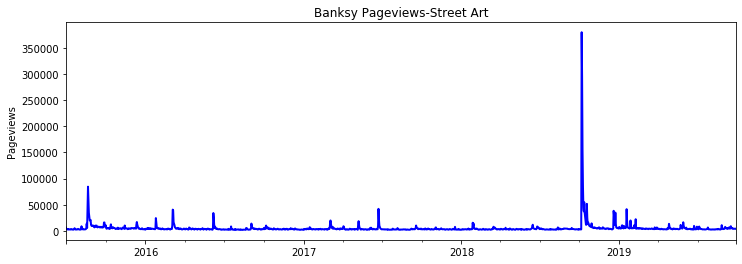

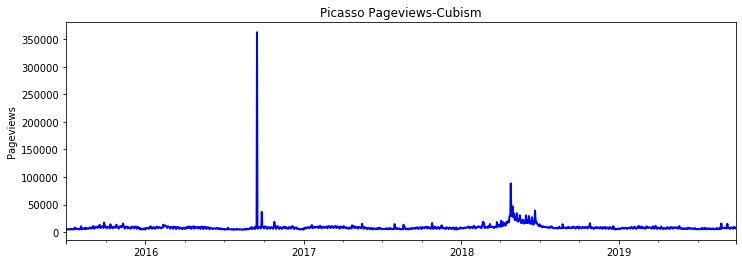

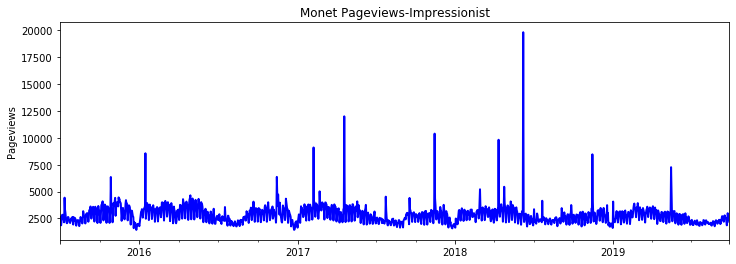

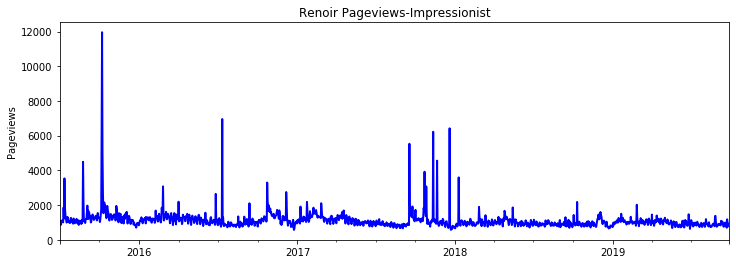

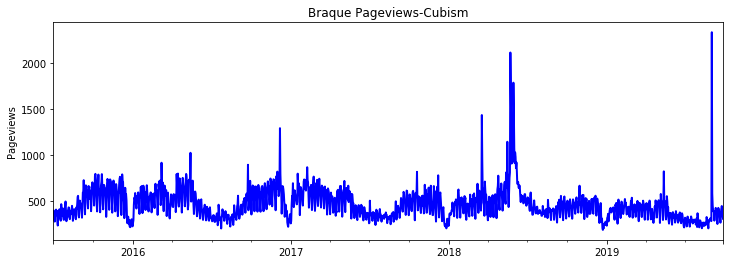

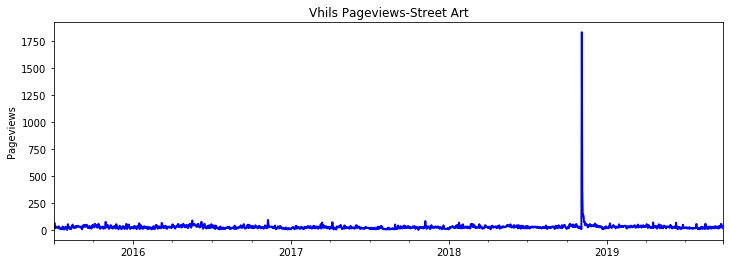

In [74]:
## f,ax = plt.subplots(1,1,figsize=(12,4))

##vhils_reindexed_df[['revisions','pageviews']].plot(lw=2,ax=ax)
##ax.set_xlabel('Year')
##ax.set_ylabel('Revisions')
##ax.set_title('Revisions')

f,ax = plt.subplots(1,1,figsize=(12,4))

banksy_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Banksy Pageviews-Street Art')

f,ax = plt.subplots(1,1,figsize=(12,4))

picasso_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Picasso Pageviews-Cubism')

f,ax = plt.subplots(1,1,figsize=(12,4))

monet_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Monet Pageviews-Impressionist')


f,ax = plt.subplots(1,1,figsize=(12,4))

renoir_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Renoir Pageviews-Impressionist')

f,ax = plt.subplots(1,1,figsize=(12,4))

braque_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Braque Pageviews-Cubism')

f,ax = plt.subplots(1,1,figsize=(12,4))

vhils_pageviews.plot(lw=2,ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Pageviews')
ax.set_title('Vhils Pageviews-Street Art')


## Why a spike in Picasso's Wikipedia views in 2016? One reason could be an article that came out about the battle between some of his family members for the money made from his work https://www.vanityfair.com/culture/2016/03/picasso-multi-billion-dollar-empire-battle

In [53]:
# compare google trends to this 
# google trends is 0-100 so will be diff than wikipedia
# normalize data so it's similar scale data.

## From Google Trends - Comparison of Street Art, Impressionism, and Cubism searches from 2016-Present 2019

## Click on the link to view interactive graphs powered by Google https://trends.google.com/trends/explore?date=2016-01-01%202019-09-27&geo=US&q=street%20art,%2Fm%2F03xj1,cubism

In [54]:
art_df = pd.read_csv('multiTimeline-2.csv')
art_df

,,,Category: All categories
Week,street art: (United States),Impressionism: (United States),cubism: (United States)
2016-01-03,67,54,24
2016-01-10,69,52,24
2016-01-17,73,59,22
2016-01-24,72,61,28
2016-01-31,73,57,29
2016-02-07,75,59,29
2016-02-14,77,54,30
2016-02-21,85,71,33
2016-02-28,82,75,34


## From Google Trends - Comparison of Street Art, Impressionism, and Cubism searches from 2014-Present 2019

## Click on this link to view interactive graphs powered by Google https://trends.google.com/trends/explore?date=2004-01-01%202019-09-27&geo=US&q=street%20art,%2Fm%2F03xj1,cubism

In [55]:
art_two_df = pd.read_csv('multiTimeline-3.csv')
art_two_df

,,,Category: All categories
Month,street art: (United States),Impressionism: (United States),cubism: (United States)
2004-01,44,72,28
2004-02,39,81,31
2004-03,39,83,38
2004-04,42,83,37
2004-05,49,100,42
2004-06,50,45,13
2004-07,37,38,11
2004-08,39,42,14
2004-09,41,56,21


In [56]:
## Maybe make a graph combining the two data sets by year! 